# Présentation du projet : 

## Contexte 

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


## Données 

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

## Mission

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

*La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.*


# Ressources : 

## Les données et leur description :

Site d'Olist (en portugais) : https://olist.com/

Adresse des données : https://www.kaggle.com/olistbr/brazilian-ecommerce

Convention PEP8 : https://www.python.org/dev/peps/pep-0008/


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P4/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P4/"

## my .py : 
from script00_lists_of_vars import *
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# Première lecture des données :

In [2]:
product_category_name_translation = pd.read_csv(data_path 
                        + "product_category_name_translation.csv")
sellers = pd.read_csv(data_path + "olist_sellers_dataset.csv")
products = pd.read_csv(data_path + "olist_products_dataset.csv")
orders = pd.read_csv(data_path + "olist_orders_dataset.csv")
order_reviews = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")
order_payments = pd.read_csv(data_path + "olist_order_payments_dataset.csv")
order_items = pd.read_csv(data_path + "olist_order_items_dataset.csv")
geolocation = pd.read_csv(data_path + "olist_geolocation_dataset.csv")
customers = pd.read_csv(data_path + "olist_customers_dataset.csv")


Je commence par regarder les liens entre les tables : 


![alt text][link_image]

[//]: # (Image References)
[link_image]:kaggle_graph_link_datasets.png "table link kaggle" 



## 1.1 Table des clients 

Ce qui nous intéresse est une classification des clients : commençons donc par explorer cette table seule. 

In [3]:
print("shape : ", customers.shape)
print("number of NaNs :",customers.isna().sum().sum(),"\n")
print(customers.info())
customers.head(2)

shape :  (99441, 5)
number of NaNs : 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


Il y a donc au total {{customers.shape[0]}} commandes, passées par  {{len(customers["customer_unique_id"].value_counts())}} clients différents. Cette table donne également 3 informations sur la localisation du client (zip code, city, state), contenues dans des variables catégorielles.

Petite vérification : Est-ce que les "customer_unique_id" ont bien tous une adresse unique ? 

In [4]:
unique_id = customers.iloc[:,1:]#["customer_unique_id"]
unique_id = unique_id.drop_duplicates(ignore_index = False)
unique_id = unique_id["customer_unique_id"]
customer_id_non_unique = unique_id.value_counts()>1
customer_id_non_unique = unique_id.value_counts()[customer_id_non_unique]
customer_id_non_unique = customer_id_non_unique.index
customer_id_non_unique = unique_id.isin(customer_id_non_unique)
customer_id_non_unique = unique_id[customer_id_non_unique].index
customers_non_unique_commande = customers.loc[customer_id_non_unique]
customers_non_unique_commande.sort_values(by="customer_unique_id").head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
87012,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,maceio,AL
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL
61403,f530197ea86ced9488a03d055e118ebf,0058f300f57d7b93c477a131a59b36c3,40731,salvador,BA
36269,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,salvador,BA
54038,e024c1515b1062b1e7e613f840c35ba3,012452d40dafae4df401bced74cdb490,3984,sao paulo,SP
45307,f8e05a045de09e7855c9df3bb8815e0e,012452d40dafae4df401bced74cdb490,3220,sao paulo,SP
91727,483468a56a54dbbbf8f2b2354cc8a729,0178b244a5c281fb2ade54038dd4b161,12518,guaratingueta,SP
57218,ea6ba2b2e27f7efea73bdeab7fd6e4a0,0178b244a5c281fb2ade54038dd4b161,14960,novo horizonte,SP
82312,026ca919d538ee454a6d43fc8bd01de0,018b5a7502c30eb5f230f1b4eb23a156,74936,aparecida de goiania,GO
64800,b98e0d5aca458a26a6ff30fee0416ca2,018b5a7502c30eb5f230f1b4eb23a156,74976,aparecida de goiania,GO


Visiblement non ! Je pense qu'il sera donc préférable d'utiliser la table ```geolocation``` pour accéder à ces information. Vérifions si cette table est plus propre : 

In [5]:
print("\t Value counts of city for zip code = 71065: \n",
    geolocation.loc[geolocation["geolocation_zip_code_prefix"] == 71065,
                    "geolocation_city"].value_counts())
print("\n\t Firsts 5 value counts of zip codes for city = maceio: \n",
      geolocation.loc[geolocation["geolocation_city"] == "maceio",
                      "geolocation_zip_code_prefix"].value_counts()[:5])

print("\n\t geolocation dataframe head :")
geolocation.head(2)

	 Value counts of city for zip code = 71065: 
 brasilia    75
brasília    10
guara        6
Name: geolocation_city, dtype: int64

	 Firsts 5 value counts of zip codes for city = maceio: 
 57035    400
57036    123
57052     99
57025     75
57010     74
Name: geolocation_zip_code_prefix, dtype: int64

	 geolocation dataframe head :


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


Eh bien non ! Il va y avoir à faire un prétraitemement sur ces variables catégorielles. Il me semble que plusieurs options sont possibles :
* nettoyer les villes, donc nettoyage de texte, comme enlever les accents, les espaces en trop, les majuscules ...
* nettoyer les codes postaux : rassembler par ville ? 
* faire appel à la table ```geolocation``` pour utiliser les coordonnées géographiques des clients (latitude et longitude). 

Dans une première intention, je propose de n'utiliser que les codes postaux (zip code) comme proxy pour la localisation, ou même utiliser l'état de résidence (customer state). 

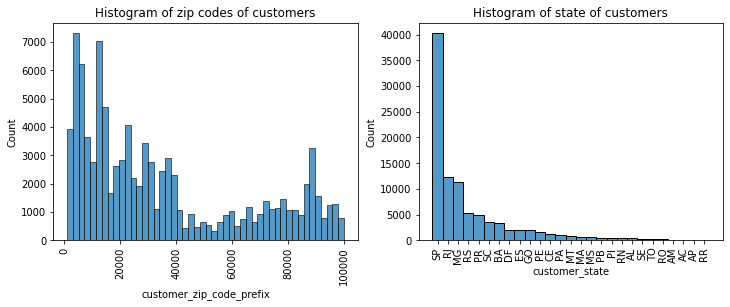

In [6]:
plt.figure(figsize=(12,4))
## removing duplicate customers (keep the 1st) :
tmp = customers.drop_duplicates(subset="customer_unique_id")

plt.subplot(1,2,1)
sns.histplot(tmp["customer_zip_code_prefix"])
plt.xticks(rotation=90)
plt.title("Histogram of zip codes of customers")

## sort by customer state values counts : 
dummy = tmp["customer_state"].value_counts().index
dummy = pd.Series(dummy, name = 'customer_state').to_frame()
tmp = pd.merge( tmp, dummy, on = "customer_state", how = 'right')

plt.subplot(1,2,2)
sns.histplot(tmp["customer_state"])
plt.xticks(rotation=90)
plt.title("Histogram of state of customers")
plt.show()

Une très grande majorité de clients sont dans l'état "SP" : a voir s'il on ne biaise pas les données en ne gardant que l'état. Les zip codes ont l'air répartis beaucoup plus homogènement, et me semblent donc à priori plus appropriés.


## 1.2 Table des commandes

### 1.2.1 Caractéristiques des commandes (orders)
Ensuite, nous cherchons à classifier les clients selon leur consommation : regardons donc l'échelle "commande".

In [7]:
print("shape : ", orders.shape)
print("number of NaNs :",orders.isna().sum().sum(),"\n")
print(orders.order_status.value_counts())
orders.head(3)

shape :  (99441, 8)
number of NaNs : 4908 

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Cette table regroupe les informations de status de la commande : la date et l'heure à laquelle elle a été passée, validée, expédiée, reçue. Elle contient aussi une variable de status qui me semble particulièrement intéressante. 

Pour les variables temporelles, je propose d'extraire plusieurs méta-variables :
* la date de commande seule
* l'heure de commande seule  
* la différence entre la date de livraison estimée et la date de livraison déclarée par le client (en jours)
* la différence entre la date de livraison déclarée par le client et la date de livraison déclarée par l'entreprise d'acheminement (en jours)

In [8]:
## Let's begin with purchase date and time split : 
purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp,
                     format = "%Y-%m-%d %H:%M:%S")

purchase_date = pd.to_datetime(purchase_timestamp.dt.date, 
                               format = "%Y-%m-%d")
purch_time = purchase_timestamp.dt.time 

In [9]:
## Then, use delta time for delivery date comparison
estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date,
                             format = "%Y-%m-%d %H:%M:%S")
delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date,
                             format = "%Y-%m-%d %H:%M:%S") 
delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date,
                             format = "%Y-%m-%d %H:%M:%S") 

delta_estimated_declared = estimated_delivery_date - delivered_customer_date
delta_estimated_declared = delta_estimated_declared / np.timedelta64(1, "D")

delta_decalared_customer_carrier = delivered_customer_date - delivered_carrier_date
delta_decalared_customer_carrier = delta_decalared_customer_carrier / np.timedelta64(1, "D")

In [10]:
## save in a working pd.DataFrame : 
my_orders = orders[['order_id', 'customer_id', 'order_status']].copy()
my_orders.at[:,"order_purchase_date"] = purchase_date
my_orders.at[:,"order_purchase_time"] = purch_time
my_orders.at[:,"order_dt_estimated_declared"] = delta_estimated_declared
my_orders.at[:,"order_dt_decalared_customer_carrier"] = delta_decalared_customer_carrier
my_orders.head(3)

,order_id,customer_id,order_status,order_purchase_date,order_purchase_time,order_dt_estimated_declared,order_dt_decalared_customer_carrier
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,10:56:33,7.107488,6.062650
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,20:41:37,5.355729,12.039410
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,08:38:49,17.245498,9.178113


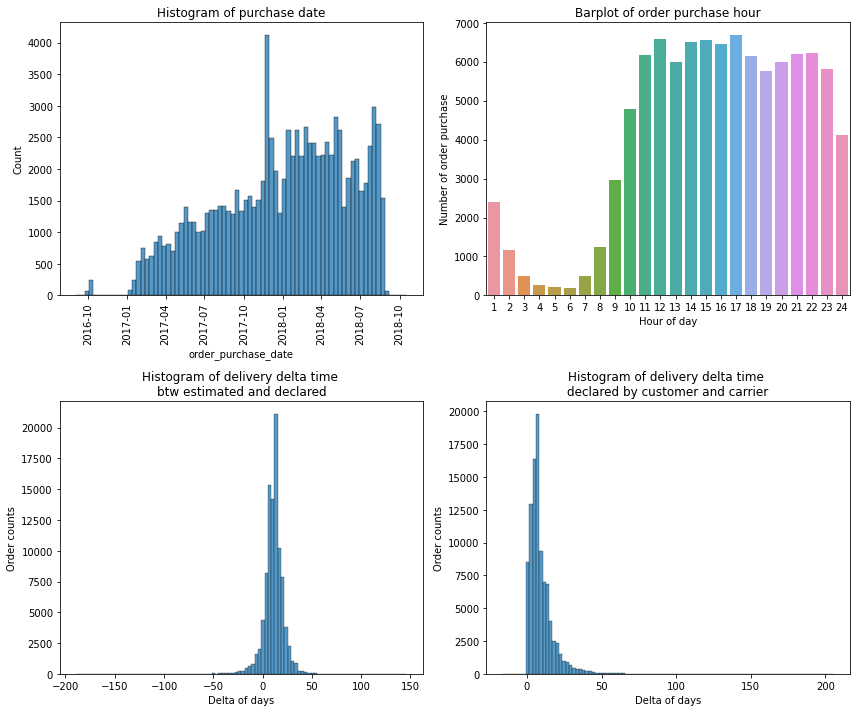

In [11]:
## Check with graphics :

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(my_orders.order_purchase_date)
plt.xticks(rotation=90)
plt.title("Histogram of purchase date")

plt.subplot(2,2,2)
tmp = pd.to_datetime(my_orders.order_purchase_time,  format = "%H:%M:%S")
tmp.groupby(tmp.dt.hour).count()
sns.barplot(x = np.arange(1,25), 
            y = tmp.groupby(tmp.dt.hour).count())
plt.title("Barplot of order purchase hour")
plt.xlabel("Hour of day")
plt.ylabel("Number of order purchase")

plt.subplot(2,2,3)
sns.histplot(my_orders.order_dt_estimated_declared, bins = 100)
plt.title("Histogram of delivery delta time \nbtw estimated and declared")
plt.xlabel("Delta of days")
plt.ylabel("Order counts")

plt.subplot(2,2,4)
sns.histplot(my_orders.order_dt_decalared_customer_carrier, bins = 100)
plt.title("Histogram of delivery delta time \ndeclared by customer and carrier")
plt.xlabel("Delta of days")
plt.ylabel("Order counts")

plt.tight_layout()
plt.show()


## TODO : Description des graphes 

## 1.2.2 Table des produits commandés (order_items)

Passons maintenant à l'étude de la table des produits commandés : 

In [12]:
print("shape : ", order_items.shape)
print("number of NaNs :",order_items.isna().sum().sum(),"\n")

order_items.head(3)

shape :  (112650, 7)
number of NaNs : 0 



,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


Cette table contient la liste des produits commandés dans différentes commandes, avec leur prix et la date limite d'envoi. La colonne "order_item_id" correspond au numéro attribué à l'article dans la commande. Est-ce que les mêmes articles sont vendus à des prix différents sur cette plateforme de vente ?

In [13]:
duplicates = order_items[order_items.duplicated(subset = "product_id", keep = False)]
duplicates = duplicates.sort_values("product_id")
duplicates.drop_duplicates(["product_id", "price"])
print("shape of duplicates after removes those with same price and name:",duplicates.shape)
duplicates.drop_duplicates(["product_id"])
print("shape of duplicates after removes those with same name :",duplicates.shape)

shape of duplicates after removes those with same price and name: (94533, 7)
shape of duplicates after removes those with same name : (94533, 7)


Il semblerait que oui. A quoi ressemble la répartition des prix ? 

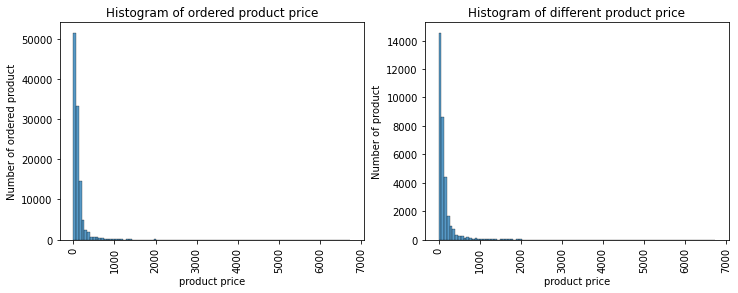

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(order_items.price, bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of ordered product price")
plt.xlabel("product price")
plt.ylabel("Number of ordered product")

plt.subplot(1,2,2)
sns.histplot(order_items.drop_duplicates(subset="product_id").price, bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of different product price")
plt.xlabel("product price")
plt.ylabel("Number of product")
plt.show()

On ne voit pas grand chose : passons en échelle log.

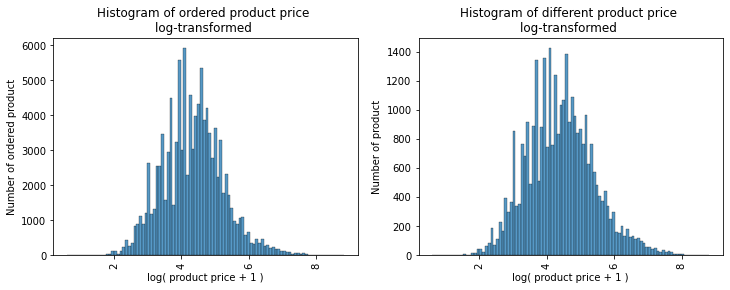

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(np.log(order_items.price+1), bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of ordered product price \nlog-transformed ")
plt.xlabel("log( product price + 1 )")
plt.ylabel("Number of ordered product")

plt.subplot(1,2,2)
sns.histplot(np.log(order_items.drop_duplicates("product_id").price
                    +1), bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of different product price \nlog-transformed ")
plt.xlabel("log( product price + 1 )")
plt.ylabel("Number of product")
plt.show()

Les commandes avec plusieurs items n'ont pas l'air de contenir des items moins cher. Regardons la répartition du prix total de chaque commande, ainsi que le fret associé :  

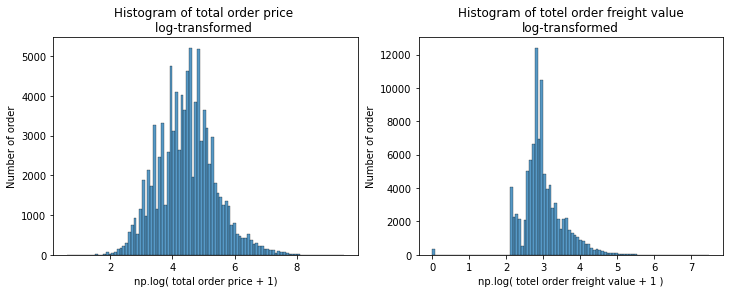

In [16]:
tmp = order_items.groupby("order_id").sum()
order_total_prices = pd.DataFrame(tmp.values, 
                                  columns = tmp.columns)
order_total_prices.at[:,"order_id"] = tmp.index

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(np.log( order_total_prices.price + 1 ), bins = 100)
plt.title("Histogram of total order price \nlog-transformed ")
plt.xlabel("np.log( total order price + 1)")
plt.ylabel("Number of order")

plt.subplot(1,2,2)
sns.histplot(np.log(order_total_prices.freight_value + 1 ), bins = 100)
plt.title("Histogram of totel order freight value\nlog-transformed")
plt.xlabel("np.log( totel order freight value + 1 )")
plt.ylabel("Number of order")
plt.show()

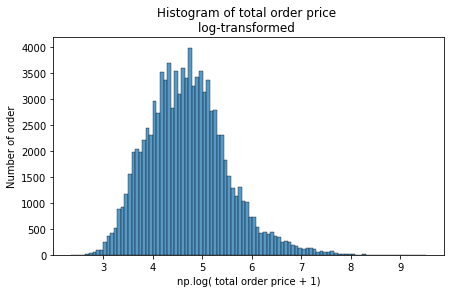

In [17]:
order_total_prices.at[:,"total"] = order_total_prices[["price","freight_value"]].sum(axis=1)

plt.figure(figsize=(7,4))
sns.histplot(np.log( order_total_prices.total + 1 ), bins = 100)
plt.title("Histogram of total order price \nlog-transformed ")
plt.xlabel("np.log( total order price + 1)")
plt.ylabel("Number of order")

plt.show()

Il n'y a rien d'inattendu : le prix des paniers en log-tranform a l'air répartis selon une loi normale. Pour le log du fret, on distingue 3 pics : un en 0, un en 2.3 et le troisième en 3.

In [18]:
my_orders = pd.merge(my_orders, order_total_prices[["order_id","price","freight_value"]], 
                     on = "order_id", how="left")
my_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_date',
       'order_purchase_time', 'order_dt_estimated_declared',
       'order_dt_decalared_customer_carrier', 'price', 'freight_value'],
      dtype='object')

### 1.2.3 Table des paiments (order_payments)

In [19]:
print("shape : ", order_payments.shape)
print("number of NaNs :",order_payments.isna().sum().sum(),"\n")

order_payments.head(3)

shape :  (103886, 5)
number of NaNs : 0 



,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


Les 4 colonnes de cette table semblent pertinentes. Il y a trois variables correspondant au moyen de paiement (type de paiement, nombre d'échéance de paiement choisis, et nombre de type de paiement), et la dernière variable est le prix payé (à comparer avec la variable "price", calculée en faisant la somme des prix de la table "order_items")

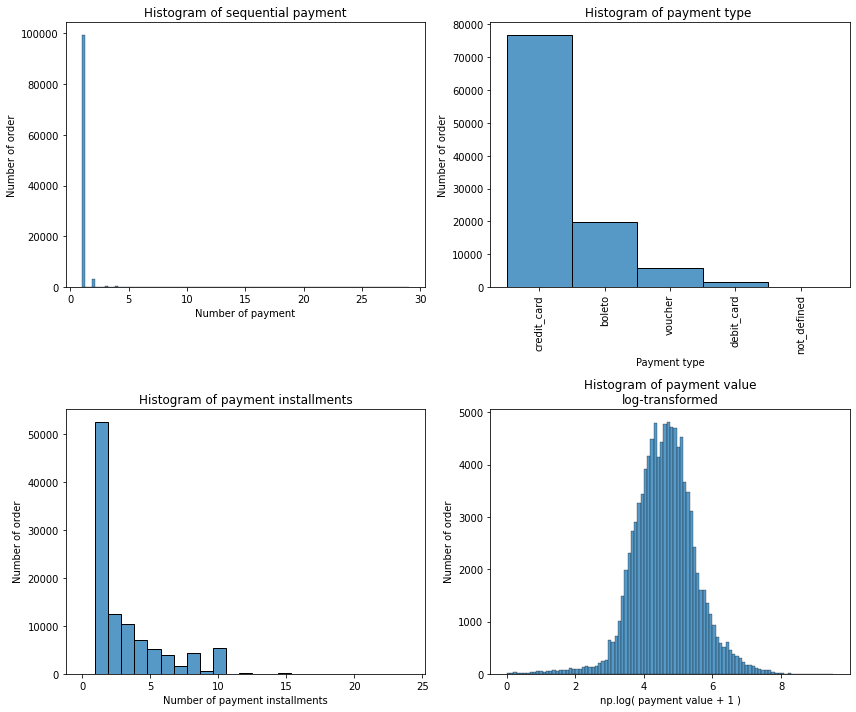

In [20]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(order_payments.payment_sequential, bins = 100)
plt.title("Histogram of sequential payment")
plt.xlabel("Number of payment")
plt.ylabel("Number of order")

plt.subplot(2,2,2)
sns.histplot(order_payments.payment_type)
plt.xticks(rotation=90)
plt.title("Histogram of payment type ")
plt.xlabel("Payment type")
plt.ylabel("Number of order")

plt.subplot(2,2,3)
sns.histplot(order_payments.payment_installments, bins = 25)
plt.title("Histogram of payment installments")
plt.xlabel("Number of payment installments")
plt.ylabel("Number of order")

plt.subplot(2,2,4)
sns.histplot(np.log(order_payments.payment_value + 1 ), bins = 100)
plt.title("Histogram of payment value\nlog-transformed")
plt.xlabel("np.log( payment value + 1 )")
plt.ylabel("Number of order")

plt.tight_layout()
plt.show()

Let us now just compare the order_payments.payment_value with the order_total_prices.total

In [21]:
sum_payments_order = order_payments[["order_id",
                "payment_value"]].groupby("order_id").sum().reset_index()
tmp = pd.merge(sum_payments_order,
         order_total_prices[["order_id","total"]], on="order_id")
index_diff_non_null = np.where(abs(tmp[["payment_value",
                            "total"]].diff(axis = 1))>10**-2)[0]
print(len(index_diff_non_null),"anomalies")
tmp.iloc[index_diff_non_null].head(3)

387 anomalies


,order_id,payment_value,total
165,00789ce015e7e5791c7914f32bb4fad4,190.81,168.83
525,016726239765c18f66826453f39c64e3,265.77,235.13
724,01e51b7c3025655646143d09b911e1d7,35.02,33.10


C'est assez étrange que les tables ne matchent pas. Il faudra faire attention à cela/demander au client si cela est normal. 

Ajoutons donc à la table d'exploitation ce qu'il semble pertinent d'extraire de cette table de paiements : 
* le nombre d'échelon de paiement 
* le type de paiement utilisé pour la majorité des payments (en terme de prix, "payment_type"). J'ai aussi regardé en terme de nombre de paiement, et en terme du plus gros paiment, les variables semblent presque identiques. 
* le nombre de type de paiement pour la commande

In [22]:
## payment_installments :
tmp = order_payments.sort_values("payment_installments",ascending=False).drop_duplicates("order_id","first")
my_orders = pd.merge(my_orders, tmp[["order_id","payment_installments"]], 
                     on="order_id", how="left")

In [23]:
# ## most frequent payment type :
# tmp = order_payments[["order_id", "payment_type"]].sort_values(by = "order_id")#"payment_type")
# tmp = pd.DataFrame(tmp.value_counts().reset_index())
# tmp = tmp.drop_duplicates("order_id")[["order_id", "payment_type"]]
# my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

In [24]:
# ## higher payment type :
# tmp = order_payments.sort_values("payment_value",
#                   ascending=False).drop_duplicates("order_id","first")
# tmp = tmp.rename(columns={"payment_type":"higher_payment_type"})
# my_orders = pd.merge(my_orders, tmp[["order_id","higher_payment_type"]], 
#                     on="order_id", how="left")

In [25]:
## most of payment type (max sum of value): 
## extract sum of payment value for each payment type : 
sub_table = order_payments[["order_id","payment_value","payment_type"]]
sub_table = sub_table.sort_values("order_id")
index = sub_table.drop_duplicates(["order_id","payment_type"]).index

tmp = sub_table.groupby(["order_id","payment_type"]).sum()
tmp = tmp.reset_index().set_index(index)

## drop duplicates where smaller payment_values (sum)
tmp = tmp.sort_values("payment_value", ascending=False)
tmp = tmp.drop_duplicates("order_id", keep="first")
my_orders = pd.merge(my_orders, tmp[["order_id","payment_type"]],
                     on="order_id", how="left")

In [26]:
## number of payment type : 
tmp = order_payments[["order_id","payment_type"]].drop_duplicates()
tmp = tmp["order_id"].value_counts().reset_index()
tmp = tmp.rename(columns={"index":"order_id", 
                          "order_id":"nb_payment_type"})
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

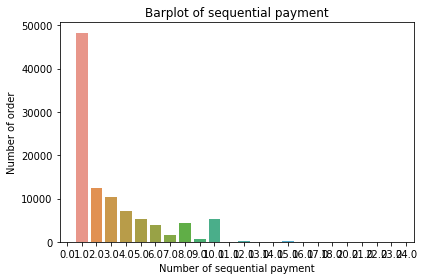

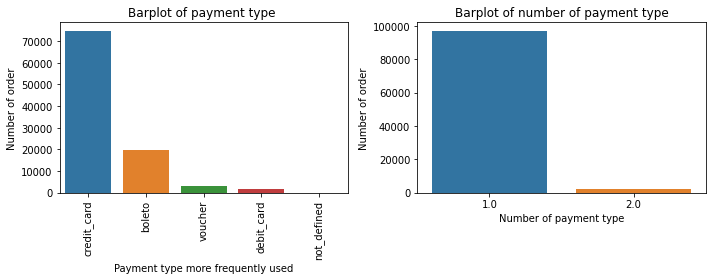

In [27]:
## graphics : 
plt.figure(figsize=(6,4))

tmp = my_orders.payment_installments.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Barplot of sequential payment")
plt.xlabel("Number of sequential payment")
plt.ylabel("Number of order")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
tmp = my_orders.payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.xticks(rotation=90)
plt.title("Barplot of payment type ")
plt.xlabel("Payment type more frequently used")
plt.ylabel("Number of order")

plt.subplot(1,2,2)
tmp = my_orders.nb_payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Barplot of number of payment type")
plt.xlabel("Number of payment type")
plt.ylabel("Number of order")

plt.tight_layout()
plt.show()

### 1.2.4 Table des paiments (order_reviews)

In [28]:
print("shape : ", order_reviews.shape)
print("number of NaNs :",order_reviews.isna().sum().sum(),"\n")

order_reviews.head(3)

shape :  (100000, 7)
number of NaNs : 146532 



,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


Il y a un très grand nombre de valeurs manquantes : 

In [29]:
order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Ces valeurs manquantes sont dans les parties textuelles des commentaires (title et message). La deuxième chose marquante dans cette table est la dimension. Est ce qu'une même commande a des scores différents ? 

In [30]:
## number of different score for one order : 
tmp = order_reviews[["order_id","review_score"]].drop_duplicates()
tmp = tmp["order_id"].value_counts()
print("there are ", sum(tmp>1), "orders with different scores")

tmp = order_reviews[["order_id","review_score"]]
tmp = tmp.value_counts()
tmp = pd.Series(tmp.groupby("order_id").count(),
                   name="count_change_scores")
tmp = tmp.reset_index()
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

there are  209 orders with different scores


In [31]:
## mean score for one order : 
tmp = order_reviews.groupby("order_id").mean().reset_index()
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

In [32]:
## add count_reviews, count_messages, count_title, for one order : 
tmp = order_reviews.groupby("order_id").count().reset_index()
tmp = tmp[["order_id","review_id", "review_comment_title", "review_comment_message"]]

dict_rename = {"review_id":"count_review"}
for colname in tmp.columns[2:] :
    new_colname = "count"
    for str1 in colname.split("_")[1:] : 
        new_colname = str(new_colname+"_"+str1)
    dict_rename[colname]=new_colname
    
tmp = tmp.rename(columns=dict_rename)
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

Possible amélioration : 
* regarder dans les messages de review pourquoi les clients sont satisfaits/non satisfaits
* prendre en compte la temporalité des commentaires


## 1.3 Les produits

In [33]:
print("shape : ", products.shape)
print("number of NaNs :",products.isna().sum().sum(),"\n")

# print(products.isna().sum())
products.head(3)

shape :  (32951, 9)
number of NaNs : 2448 



,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


Je propose d'utiliser une NMF sur les produits, afin de chercher à les regrouper en des sens sémantiques, et utiliser ce réduction de dimension pour qualifier les paniers : est ce que les produits achetés sont des hauts de gamme ? est ce qu'il s'agit de biens de consommation ? La constitution du panier est-il homogène ou hétérogène ? 

Pour choisir les paramètre de réduction de dimension qui correspondent le mieux à l'utilisation, je propose de l'utiliser pour prédire la catégorie du produit. 

In [227]:
## extract numeric table with id as index
X = products.copy()

X = X.set_index("product_id")
y = X["product_category_name"]
# y = y.fillna("missing")
missing_index = y[y.isna()].index
y = y.drop(index=missing_index)
X = X.drop(index=missing_index)
X = X.loc[:,~(X.dtypes == object)]

n_clusters = len(np.unique(y))
X.shape

(32341, 7)

Pour utiliser les pipelines de sklearn, j'ai besoin de n'avoir aucune valeur manquante. Je vais donc imputer les valeurs manquantes numériques par un algorithme des plus proches voisins, les valeurs manquantes catégorielles sont remplacées par une nouvelle catégorie 'missing'.

MSE = 363.840 (+/-5.289) for {'n_neighbors': 1}
MSE = 312.258 (+/-2.723) for {'n_neighbors': 2}
MSE = 293.258 (+/-2.890) for {'n_neighbors': 3}
MSE = 284.657 (+/-4.534) for {'n_neighbors': 4}
MSE = 278.012 (+/-3.873) for {'n_neighbors': 5}
MSE = 273.478 (+/-3.539) for {'n_neighbors': 6}
MSE = 270.014 (+/-3.446) for {'n_neighbors': 7}
MSE = 267.433 (+/-3.007) for {'n_neighbors': 8}
MSE = 265.345 (+/-2.872) for {'n_neighbors': 9}
MSE = 263.750 (+/-2.756) for {'n_neighbors': 10}
MSE = 262.441 (+/-2.686) for {'n_neighbors': 11}
MSE = 261.276 (+/-2.720) for {'n_neighbors': 12}
MSE = 260.375 (+/-2.538) for {'n_neighbors': 13}
MSE = 259.540 (+/-2.522) for {'n_neighbors': 14}


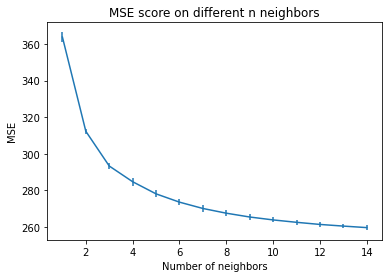

In [274]:
## Standardization for missing values imputation :
my_std = StandardScaler().fit(X)
X_std = pd.DataFrame(my_std.transform(X), 
                     columns=X.columns, index = X.index)

## missing values treatment : 
my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,15,1)}
cv = 4

# res = launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
## Save dictionnary of results : 
# with open(res_path+"set_n_KNN_impute_products"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"set_n_KNN_impute_products"+".pkl", "rb") as f :
        res = pickle.load(f)
fig_name = None
plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

n_neighbors = 10 
## Impute missing values :
imputer = KNNImputer(n_neighbors=n_neighbors)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = my_std.inverse_transform(pred_std)
X = pd.DataFrame(pred, index = X.index, columns = X.columns)
X_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

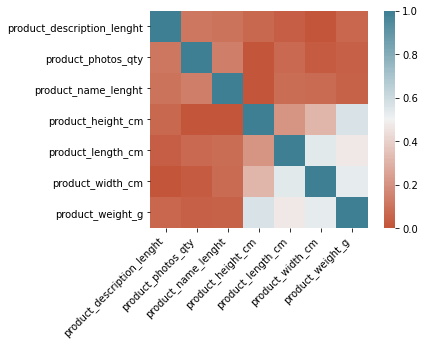

In [275]:
plot_heatmap_dist(X.corr())

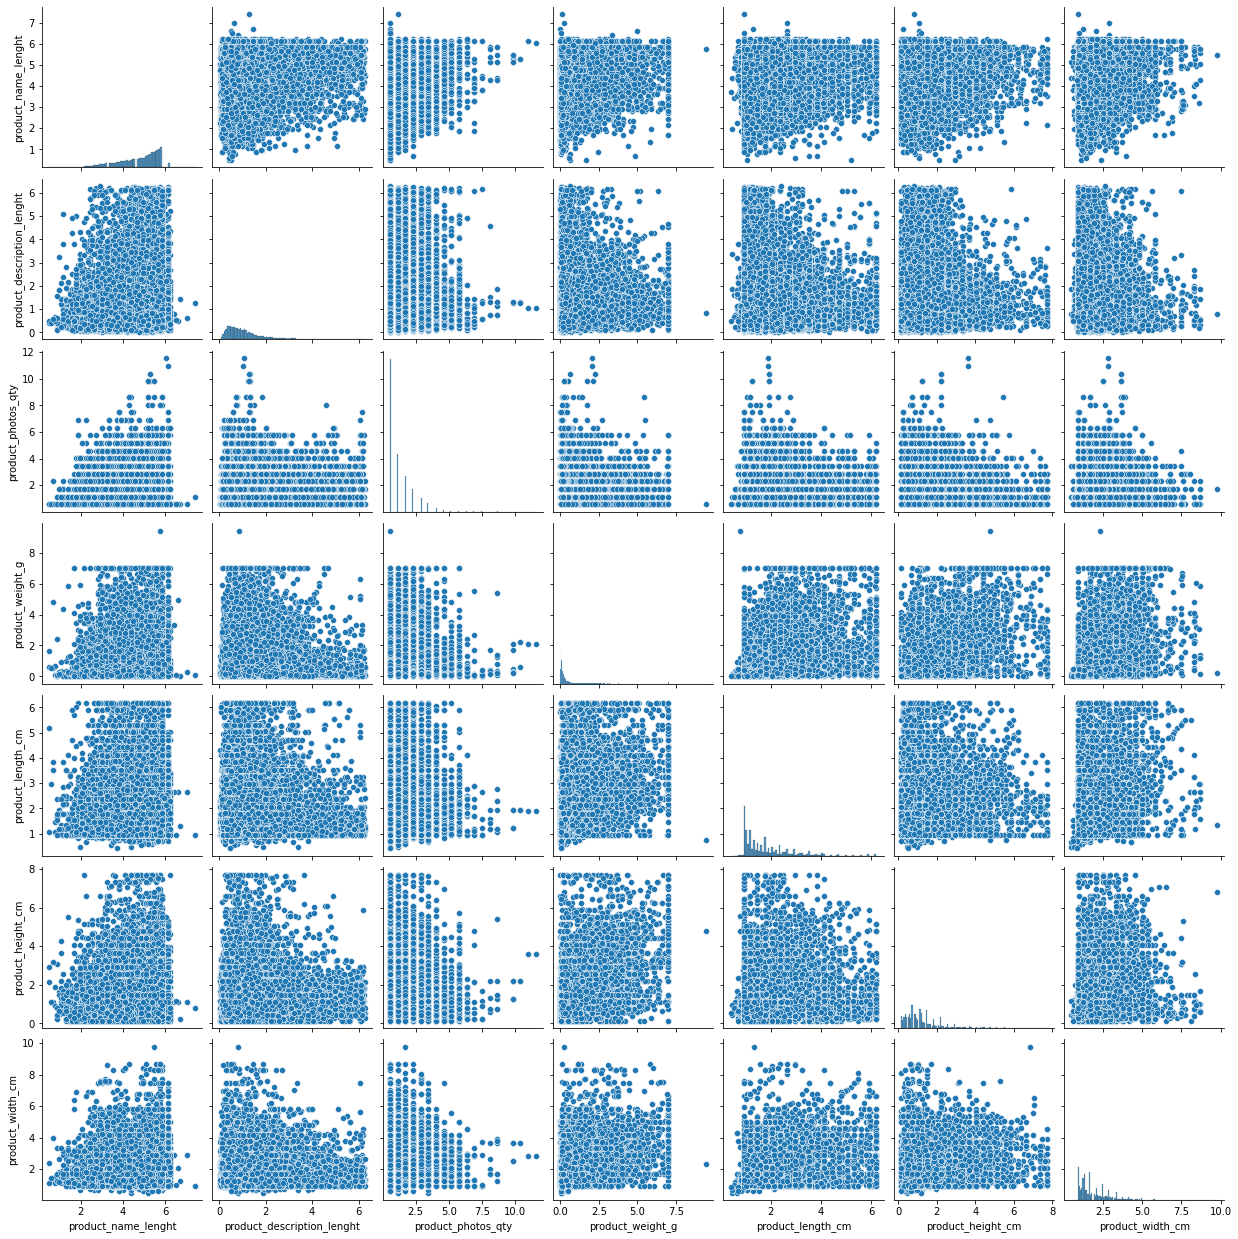

In [286]:
my_std2 = StandardScaler(with_mean = False)
X_std2 = pd.DataFrame(my_std2.fit_transform(X),
                      columns=X.columns, index=X.index) 
tmp = pd.merge(y, X_std2, left_index=True, right_index=True)
sns.pairplot(tmp)

Je me suis en grande partie inspirée de ce code pour écrire ce qui suit : https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

In [238]:
pipe = Pipeline([
    ('reduce_dim', NMF(max_iter = 10000,init='random')),
    ("standardize", StandardScaler()),
    ('classify', KMeans(n_clusters = n_clusters, max_iter=1000, init="k-means++"))
])

N_COMPONENTS_OPTIONS = np.arange(1, X.shape[1]+1)
ALPHA_OPTION =  np.arange(0,0.7,0.05)
L1_RATIO_OPTION =  np.arange(0,1.1,0.2)
param_grid = [
    {   'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'reduce_dim__alpha': ALPHA_OPTION,
        'reduce_dim__l1_ratio': L1_RATIO_OPTION,
    },
]
# grid = GridSearchCV(pipe, n_jobs=5, param_grid=param_grid)
# grid.fit(X, y)
# ## Save dictionnary of results : 
# res = grid.cv_results_
# with open(res_path+"NMF_reduce_dim_products"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
# best_params = grid.best_params_
# with open(res_path+"NMF_reduce_dim_best_params_products"+".pkl", "wb") as f :
#     pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


with open(res_path+"NMF_reduce_dim_products"+".pkl", "rb") as f :
    res = pickle.load(f)
with open(res_path+"NMF_reduce_dim_best_params_products"+".pkl", "rb") as f :
    best_params = pickle.load(f)

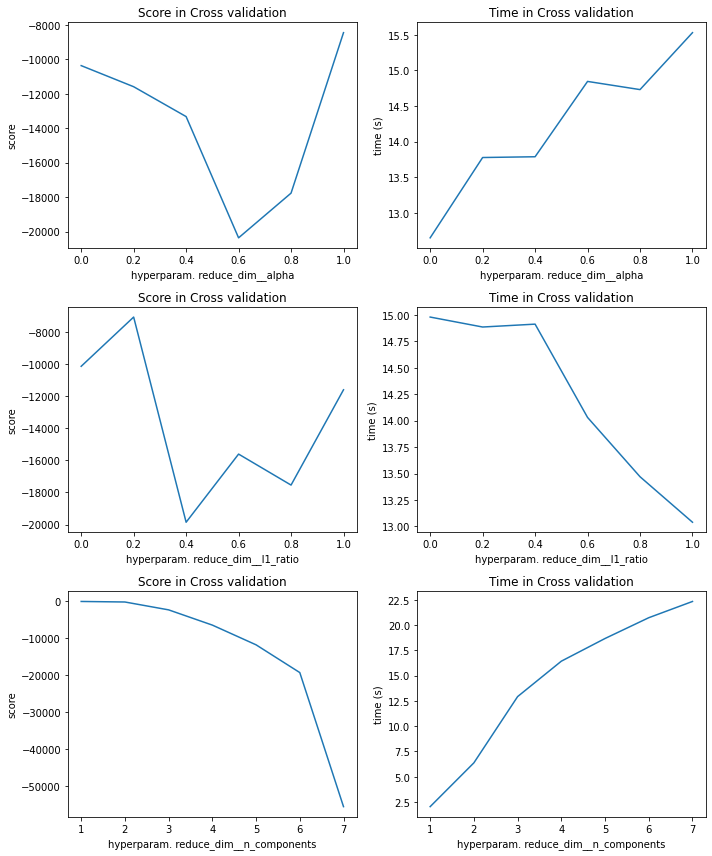

In [231]:
dict_log_param = {"reduce_dim__n_components" : False,
                  "reduce_dim__alpha" : False,
                  "reduce_dim__l1_ratio" : False}

plot_cv_res_pipe(res,dict_log_param)
plt.tight_layout()

In [239]:
best_params

{'reduce_dim__alpha': 0.4,
 'reduce_dim__l1_ratio': 0.6000000000000001,
 'reduce_dim__n_components': 1}

**score MSE à -50000 ?? recalculer en choisissant un MSE comme score dans grid search**

Visiblement, deux dimensions suffisent pour représenter fidèlement le dataset sur les produits : pour en avoir le coeur net, je vais relancer ce GridSearchCV sur les meilleurs hyperparamètres de régularisation. 

In [242]:
# best_params = {"reduce_dim__alpha": 0.8, "reduce_dim__l1_ratio":0.8}
pipe.set_params(**best_params)

N_COMPONENTS_OPTIONS = np.arange(1, X.shape[1]+1)
param_grid = [{'reduce_dim__n_components': N_COMPONENTS_OPTIONS}]

grid = GridSearchCV(pipe, cv = 5, n_jobs=5, param_grid=param_grid)
grid.fit(X, y)
# Save dictionnary of results : 
res = grid.cv_results_
with open(res_path+"NMF_reduce_dim2_products"+".pkl", "wb") as f :
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
best_params = grid.best_params_
with open(res_path+"NMF_reduce_dim2_best_params_products"+".pkl", "wb") as f :
    pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


# with open(res_path+"NMF_reduce_dim2_products"+".pkl", "rb") as f :
#     res = pickle.load(f)
# with open(res_path+"NMF_reduce_dim2_best_params_products"+".pkl", "rb") as f :
#     best_params = pickle.load(f)

/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


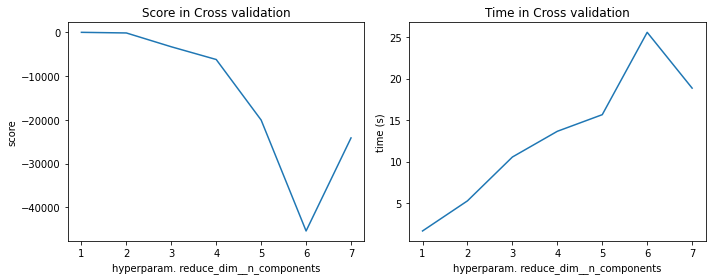

In [243]:
res = grid.cv_results_
plot_cv_res_pipe(res,dict_log_param)
plt.tight_layout()

**toujours ce pb de score hyper négatif**

Deux composantes semblent donc bien suffir (à vérifier les résultats en terme de coeff avec une seule). Je propose de vérifier si ces projections sont sémantiques, en regardant la traduction des catégories de produit  : 

In [192]:
best_params["reduce_dim__n_components"]= 7
pipe.set_params(**best_params)

def plot_coeffs(my_meth, X_, X_name= "X"):
    '''
    from dim reduceur, plot coefficients of the 2 first axis
    and return coefficients on whole axis
    
    Parameters:
    -----------------------------------------
    my_meth = sklearn.decomposition methode like PCA of NMF 
    X_ = pd.DataFrame() of data to be reduced
    
    Returns:
    -----------------------------------------
    pd.DataFrame of coefficients
    '''
    my_meth.set_params(**{"n_components": X_.shape[1]})
    my_meth.fit(X_)

    coeffs = pd.DataFrame(my_meth.components_, columns = X_.columns,
                          index = ["ax_"+str(k) for k in np.arange(1,my_meth.n_components+1)])
    for colname in coeffs.columns :
        plt.scatter(x = coeffs.loc["ax_1", colname], 
                    y = coeffs.loc["ax_2", colname],
                    label = colname)
    plt.xlabel("coeff axis 1")
    plt.ylabel("coeff axis 2")
    my_meth_name = str(my_meth).split("(")[0]
    plt.title(my_meth_name+" on "+ str(X_name))

    plt.legend()
    return(coeffs)

Il y a donc deux colonnes qui résument presque à elles seules la table, il s'agit de la longeur de la description du produit et du poids.Je jette un coup d'oeil à l'ACP : 

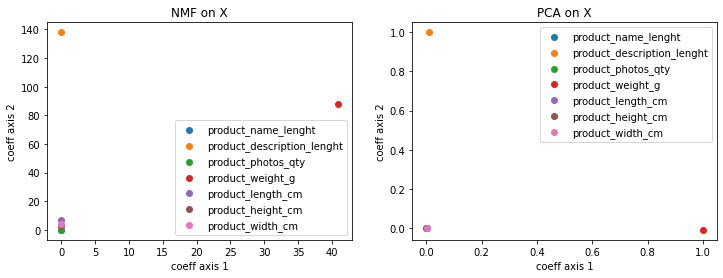

In [193]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_coeffs(pipe["reduce_dim"],X)
plt.subplot(1,2,2)
plot_coeffs(PCA(),X)
plt.show()

Et pour éviter les problèmes d'échele, j'essaie sur une matrice réduite (non centrée car le nmf ne peut tourner s'il y a des valeurs négatives) 

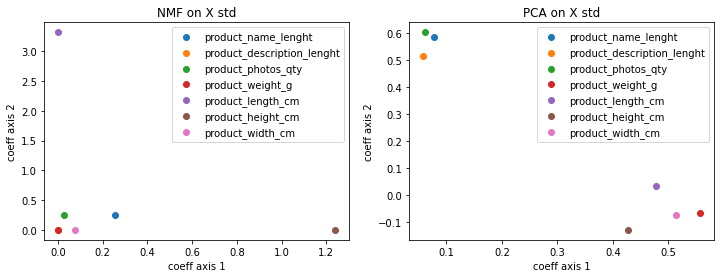

In [194]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_coeffs(pipe["reduce_dim"],X_std2,"X std")
plt.subplot(1,2,2)
plot_coeffs(PCA(),X_std2,"X std")
plt.show()

Le premier axe de la nmf est principalement constitué de la hauteur du produit,avec un poids 6 fois plus petit pour la longueur du nom du produit. Le deuxième axe est tiré par la longueur du produit. Les autre colonnes ont des poids négligeables. 
L'ACP quant à elle regroupe les variables en deux catégories : 
* les dimensions du produit : longueur, largeur, hauteur, épaisseur. 
* les méta-données : la longueur du nom du produit, la longueur de la description, et la qualité de la photo

Lorsque les données sont réduite, on voit qu'il y avait clairement un effet d'échelle ! Je propose donc de relancer la grid search CV sur la table réduite (non centrée). 

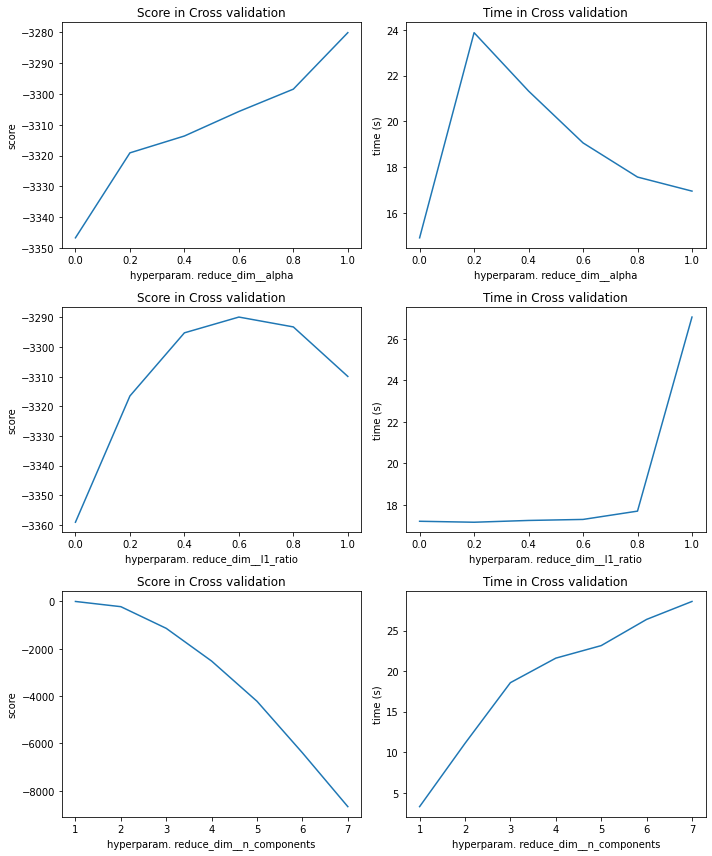

In [210]:
pipe = Pipeline([
    ('reduce_dim', NMF(max_iter = 10000,init='random')),
    ("standardize", StandardScaler()),
    ('classify', KMeans(n_clusters = , max_iter=1000, init="k-means++"))
])

N_COMPONENTS_OPTIONS = np.arange(1, X.shape[1]+1)
ALPHA_OPTION =  np.arange(0,1.1,0.2)
L1_RATION_OPTION =  np.arange(0,1.1,0.2)
param_grid = [
    {   'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'reduce_dim__alpha': ALPHA_OPTION,
        'reduce_dim__l1_ratio': L1_RATION_OPTION,
    },
]
# grid = GridSearchCV(pipe, n_jobs=5, param_grid=param_grid)
# grid.fit(X_std2, y)
# ## Save dictionnary of results : 
# res = grid.cv_results_
# with open(res_path+"NMF_reduce_dim_products_std"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
# best_params = grid.best_params_
# with open(res_path+"NMF_reduce_dim_best_params_products_std"+".pkl", "wb") as f :
#     pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


with open(res_path+"NMF_reduce_dim_products_std"+".pkl", "rb") as f :
    res = pickle.load(f)
with open(res_path+"NMF_reduce_dim_best_params_products_std"+".pkl", "rb") as f :
    best_params = pickle.load(f)
    
plot_cv_res_pipe(res,dict_log_param)
plt.tight_layout()

Je me rappelle bien qu'il faut un produit qui puisse être exploité par l'équipe marketing d'olist, ainsi, je pense qu'il est pertinent de réduire la base de données "produit" avec l'ACP (car sémantique simple d'interprétation) pour permettre le traitement automatique de cette table. Par cela, j'entends lancer une ACP sur les deux groupe, pour avoir une projection à une dimension des variables "dimensions" et "description", et en faire deux variables sur lesquelles projeter les commandes.

In [254]:
cls = KMeans(n_clusters=n_clusters)

[0.33527159 0.50951207]


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


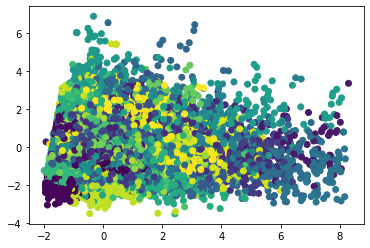

In [267]:
my_pca = PCA(n_components=2).fit(X_std2)
print(my_pca.explained_variance_ratio_.cumsum())

X_proj = my_pca.transform(X_std2)
# cls = y.astype("category")
cls = KMeans(n_clusters=n_clusters)
cls.fit(X_std2)

plt.scatter(x=X_proj[:,0], y=X_proj[:,1], c=cls.labels_)

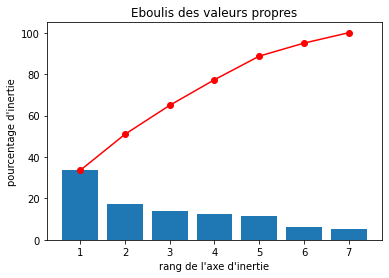

In [244]:
from script06_reduce_dim import *
my_pca = PCA().fit(X_std2)
display_scree_plot(my_pca)

In [198]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [ ]:
my_orders["order_purchase_date"]

In [ ]:
my_orders.dtypes
df = my_orders.copy()
df.select_dtypes(include=['object','datetime64[ns]' ])

## 1.x Lien entre les tables :

In [ ]:
# sellers, products, orders, order_reviews, 
# order_items, geolocation, customers

## customer-order
customer_order = pd.merge(customers[["customer_unique_id","customer_id"]], 
    orders[["customer_id","order_id"]], 
    on = "customer_id", how = 'right')


In [ ]:
customers[["customer_unique_id","customer_id"]]

In [ ]:
pca = sklearn.decomposition.PCA(2)
pca.fit(XT)
pca.components_

In [ ]:
X_train, X_test = train_test_split(X, train_size=0.80)
std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [ ]:

def plot_line(x,y,f=1):
    x1 = f*min(x,0)
    x2 = f*max(x,0)
    y1 = f*min(y,0)
    y2 = f*max(y,0)
    print([x1,y1],[x2,y2])
    plt.plot([x1,y1],[x2,y2])
    
X = np.array([[1,1],[3,1],[1,2],[2,0]]).transpose()
XT = X.transpose()


XXT = np.dot(X,XT)
XXT_norm = XXT/np.linalg.norm(XXT)
np.linalg.eig(XXT)

In [ ]:
plt.scatter(XT[:,0],XT[:,1])
# plt.plot([-0.7352,0],[0,0.6779])


plot_line(x = 0, y = 1,f = 1)

